In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [48]:
import math
import os.path

import keras
import librosa.feature
import sklearn

import pandas
import numpy
from matplotlib import pyplot as plt

In [33]:


def load_dataset(path):
    metadata_path = os.path.join(path, 'metadata/UrbanSound8K.csv')
    samples = pandas.read_csv(metadata_path)
    return samples

dataset_path = '../../data/UrbanSound8K/'
def sample_path(sample):
    return os.path.join(dataset_path, 'audio', 'fold'+str(sample.fold), sample.slice_file_name)

data = load_dataset(dataset_path)
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


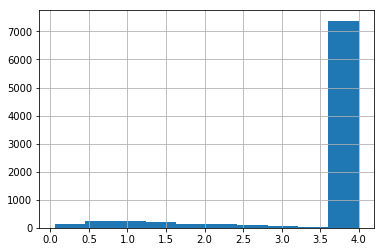

In [38]:
(data.end - data.start).hist()

In [73]:
def load_sample(sample, sr=16000, n_mels=32, n_fft=1024, hop_length=512, pad_length=126):
    path = sample_path(sample)
    y, sr = librosa.load(path, sr=sr)
    mels = librosa.feature.melspectrogram(y, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    log_mels = librosa.core.power_to_db(mels, top_db=80, ref=numpy.max)
    
    if pad_length:
        out = numpy.full((n_mels, 126), -80)
        out[:, 0:log_mels.shape[1]] = log_mels
    else:
        out = log_mels
    
    return out
    
load_sample(data.iloc[91]).shape

(32, 126)

In [74]:
# Use fold=10 for testing, as recommended by Urbansound8k dataset authors
def split_dataset(data, val_size=0.2):
    train = data[data.fold != 10]
    test = data[data.fold == 10]

    from sklearn.model_selection import train_test_split
    train, val = train_test_split(train, test_size=val_size)

    return train, val, test
                 
train, validate, test = split_dataset(data)
train.shape, validate.shape, test.shape

((6316, 8), (1579, 8), (837, 8))

In [99]:
def gen(X, Y, loader, batchsize=10):
    n_classes = len(numpy.unique(Y))
    
    sample_idx = 0
    while True:
        batch_data = []
        batch_labels = []
        
        while len(batch_data) < batchsize:
            if sample_idx >= len(X):
                break
            
            data = loader(X.iloc[sample_idx])
            data = numpy.expand_dims(data, -1)
            
            y = Y.iloc[sample_idx]
            y = keras.utils.to_categorical(y, num_classes=n_classes)
            
            batch_data.append(data)
            batch_labels.append(y)
            sample_idx += 1
            
        batch = (numpy.stack(batch_data), numpy.stack(batch_labels))
        #print('b', batch[0].shape, batch[1].shape)
        yield batch
            
            
g = gen(train, train.classID, loader=load_sample, batchsize=2)
b = next(g)
b[0].shape, b[1].shape

((2, 32, 126, 1), (2, 10))

In [ ]:

import dense
import dilated
model = dilated.build_model(bands=32, frames=126, channels=1)

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


batch_size = 30
train_gen = gen(train, train.classID, loader=load_sample, batchsize=batch_size)
val_gen = gen(validate, validate.classID, loader=load_sample, batchsize=batch_size)

model.fit_generator(train_gen, validation_data=val_gen,
                    steps_per_epoch=math.ceil(len(train)/batch_size),
                    validation_steps=math.ceil(len(validate)/batch_size),
                    epochs=10, verbose=1)

Epoch 1/10
 21/211 [=>............................] - ETA: 23:21 - loss: 2.6972 - acc: 0.1143